# TP1 ACN 2025 – Simulación AEP
Este notebook usa `aep_sim.py` y sigue el estilo de las clases (NumPy, Monte Carlo, matplotlib).

## Contenidos
1. Parámetros y funciones auxiliares
2. Simulación base (sin eventos de clima)
3. Experimentos para distintos $\lambda\in\{0.02, 0.1, 0.2, 0.5, 1\}$
4. Día ventoso (interrupciones 10%)
5. Cierre sorpresivo de 30 minutos
6. Visualizaciones (timeline de aterrizajes, evolución de distancias)
7. Resumen de métricas con error de estimación


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import aep_sim; reload(aep_sim)
from aep_sim import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()

23.4

### Ej 1 - Simulación base
Corramos una simulación con $\lambda=0.1$ para visualizar resultados.

In [2]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
sim = AEPSimulator(cfg)
out = sim.run()
out.landed, out.diverted, out.avg_delay_minutes

(81, 33, 0.30370370370370514)

In [3]:
print("📊 Resultados de la simulación:")
print(f"✈️ Aviones aterrizados: {out.landed}")
print(f"🔀 Aviones desviados: {out.diverted}")
print(f"⏱️ Demora promedio: {out.avg_delay_minutes:.2f} minutos")
print(f"🔁 Go-arounds: {out.go_arounds}")
print(f"⏳ Tiempo total en congestión: {out.congestion_time} min")


📊 Resultados de la simulación:
✈️ Aviones aterrizados: 81
🔀 Aviones desviados: 33
⏱️ Demora promedio: 0.30 minutos
🔁 Go-arounds: 45
⏳ Tiempo total en congestión: 61 min


### Timeline de aterrizajes

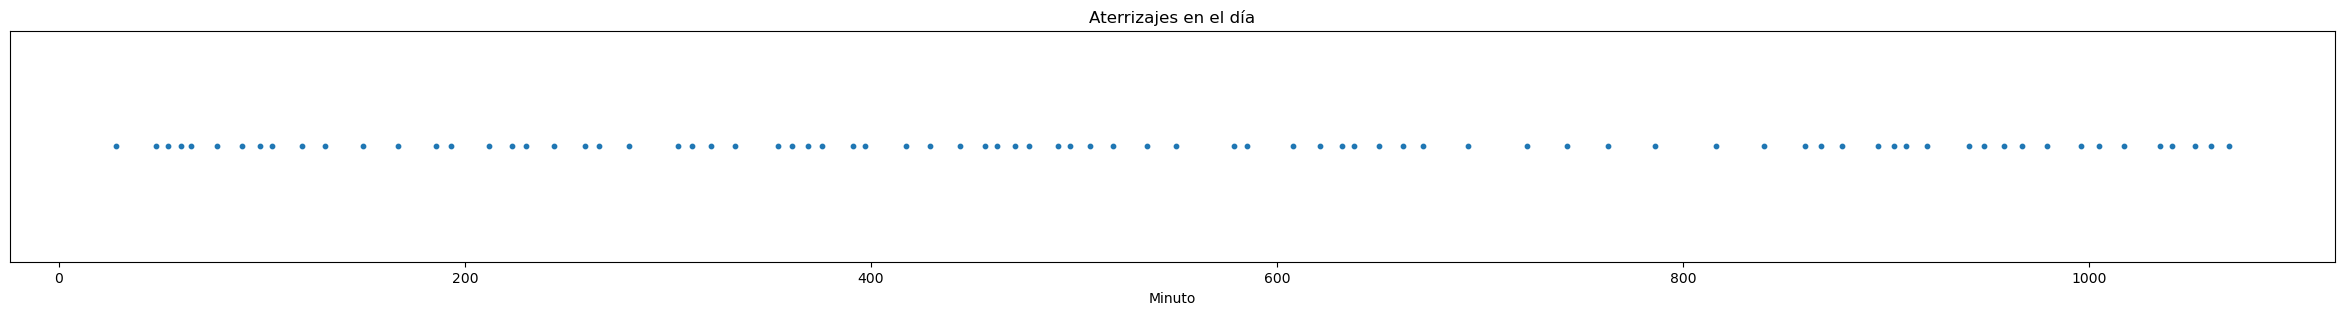

In [4]:
plt.figure(figsize=(30,3))
y = np.zeros(len(out.timeline_landings))
plt.scatter(out.timeline_landings, y, s=10)
plt.yticks([]); plt.xlabel('Minuto'); plt.title('Aterrizajes en el día')
plt.show()

Sí, es esperable que los puntos estén separados de manera casi equitativa si los aterrizajes ocurren a intervalos regulares (por ejemplo, cada 10 minutos, 12 minutos, etc.), como suele pasar con una tasa de arribo baja y sin congestión.
Esto indica que el sistema está funcionando de manera ordenada y no hay acumulación ni congestión significativa.

Si tu simulación tiene λ bajo y no hay eventos disruptivos, los aterrizajes deberían verse así: espaciados y regulares.
Si aumentás λ o agregás congestión, deberías ver puntos más juntos o agrupados.

Trayectorias distancia–tiempo

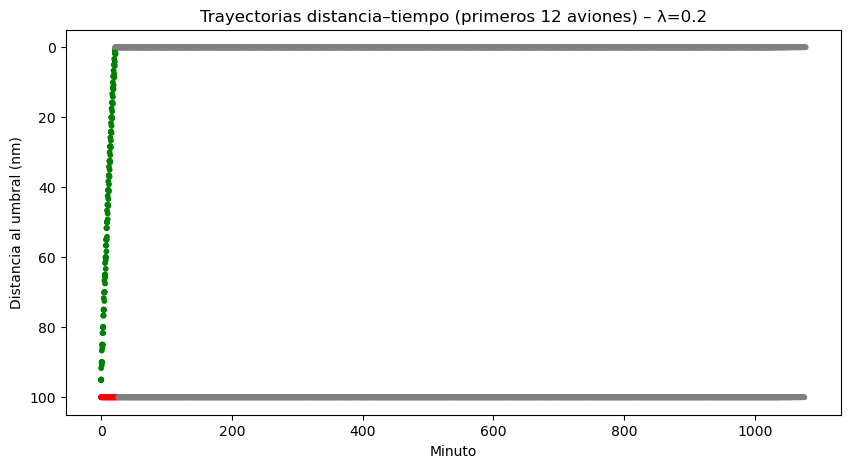

In [5]:
from aep_sim import OPERATION_MINUTES, desired_speed_max_for_distance_nm

cfg = SimulationConfig(lambda_per_min=0.2, seed=777)
sim = AEPSimulator(cfg)

# Logs por minuto: {id: [dist_t0, dist_t1, ...]}
dist_log = {}
status_log = {}

for minute in range(OPERATION_MINUTES):
    # registrar estado ANTES del paso
    for a in sim.aircrafts:
        if a.id not in dist_log:
            dist_log[a.id] = []
            status_log[a.id] = []
        dist_log[a.id].append(a.distance_nm)
        status_log[a.id].append(a.status)
    # avanzar 1 minuto
    sim.step(minute)

# -----------------------------
# Gráfico distancia-tiempo con colores por estado
# -----------------------------
N = 12  # primeras N trayectorias
plt.figure(figsize=(10,5))
for aid in sorted(dist_log.keys())[:N]:
    series = dist_log[aid]
    statuses = status_log[aid]
    # definir colores según estado
    colors = ['green' if s=='approach' else 'red' if s=='go_around' else 'gray' for s in statuses]
    plt.scatter(range(len(series)), series, c=colors, s=10)
plt.gca().invert_yaxis()
plt.xlabel("Minuto")
plt.ylabel("Distancia al umbral (nm)")
plt.title(f"Trayectorias distancia–tiempo (primeros {N} aviones) – λ=0.2")
plt.show()


Verde: El avión está en "approach" (acercándose normalmente).
Rojo: El avión está en "go-around" (tuvo que abortar el aterrizaje y alejarse).
Gris: Otros estados (por ejemplo, ya aterrizó, desviado, o no está activo).
Interpretación:

Cada nube de puntos de un color representa la trayectoria de un avión a lo largo del tiempo.
Las trayectorias verdes bajan de 100 a 0 nm: el avión se acerca y aterriza.
Si ves puntos rojos, indican momentos en que el avión hizo go-around (se aleja en vez de seguir acercándose).
Las líneas horizontales grises en 100 nm y 0 nm indican minutos donde el avión aún no apareció o ya terminó su trayecto (por eso se ven muchos puntos grises).

### Ej 3
Probabilidad de 5 arribos en una hora

In [6]:
import numpy as np
from math import comb, exp, factorial

# Parámetros "modo clase"
n = 60              # 60 minutos
p = 1/60            # prob. por minuto
k = 5               # queremos 5 arribos en una hora

# Analítico: Binomial(n=60, p=1/60)
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))

# Aprox Poisson con lambda=1 por hora
lam = 1.0
poiss_pmf = exp(-lam) * (lam**k) / factorial(k)

# Monte Carlo simple
rng = np.random.default_rng(123)
N = 200_000
samples = rng.binomial(n=n, p=p, size=N)
mc_est = np.mean(samples == k)
mc_se  = np.sqrt(mc_est*(1-mc_est)/N)  # error estándar

print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")
print(f"P(X=5) Poisson(1)      = {poiss_pmf:.6f}")
print(f"P(X=5) Monte Carlo      = {mc_est:.6f} ± {1.96*mc_se:.6f} (95% IC)")


P(X=5) Binomial exacta = 0.002787
P(X=5) Poisson(1)      = 0.003066
P(X=5) Monte Carlo      = 0.002960 ± 0.000238 (95% IC)


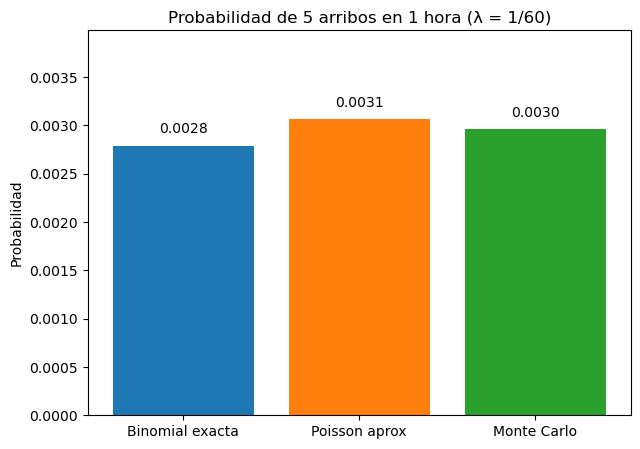

P(X=5) Binomial exacta = 0.002787
P(X=5) Poisson(1)      = 0.003066
P(X=5) Monte Carlo      = 0.002960 ± 0.000238 (95% IC)


In [7]:
import numpy as np
from math import comb, exp, factorial
import matplotlib.pyplot as plt

# Parámetros
n = 60
p = 1/60
k = 5

# Cálculos
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))
lam = 1.0
poiss_pmf = exp(-lam) * (lam**k) / factorial(k)

rng = np.random.default_rng(123)
N = 200_000
samples = rng.binomial(n=n, p=p, size=N)
mc_est = np.mean(samples == k)
mc_se  = np.sqrt(mc_est*(1-mc_est)/N)

# Valores y etiquetas
labels = ["Binomial exacta", "Poisson aprox", "Monte Carlo"]
values = [binom_pmf, poiss_pmf, mc_est]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Gráfico
plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors)
plt.ylabel("Probabilidad")
plt.title("Probabilidad de 5 arribos en 1 hora (λ = 1/60)")

# Etiquetas arriba de cada barra
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + 0.0001,
             f"{val:.4f}",
             ha='center', va='bottom')

plt.ylim(0, max(values)*1.3)

# Guardar la figura
plt.savefig("prob_5_arribos.png", dpi=200, bbox_inches="tight")

plt.show()

print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")
print(f"P(X=5) Poisson(1)      = {poiss_pmf:.6f}")
print(f"P(X=5) Monte Carlo      = {mc_est:.6f} ± {1.96*mc_se:.6f} (95% IC)")


### EJ 4
Experimentos para varios $\lambda$ (promedios y error estándar)

In [8]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=20, seed=123)
#res

In [9]:
print("📊 Resultados promedio por λ:")
for lam, stats in res.items():
    print(f"\nλ = {lam}")
    print(f"✈️ Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"🔀 Desviados: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"⏱ Demora promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f}")
    print(f"🔁 Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")


📊 Resultados promedio por λ:

λ = 0.02
✈️ Aterrizados: 22.05 ± 1.14
🔀 Desviados: 0.40 ± 0.15
⏱ Demora promedio: -0.24 ± 0.16
🔁 Go-arounds: 2.40 ± 0.34

λ = 0.1
✈️ Aterrizados: 79.40 ± 0.96
🔀 Desviados: 25.05 ± 0.97
⏱ Demora promedio: 0.29 ± 0.11
🔁 Go-arounds: 33.75 ± 1.37

λ = 0.2
✈️ Aterrizados: 116.70 ± 0.87
🔀 Desviados: 93.60 ± 2.66
⏱ Demora promedio: -0.82 ± 0.06
🔁 Go-arounds: 99.35 ± 2.95

λ = 0.5
✈️ Aterrizados: 162.90 ± 0.54
🔀 Desviados: 371.60 ± 3.09
⏱ Demora promedio: -0.90 ± 0.01
🔁 Go-arounds: 380.25 ± 3.19

λ = 1.0
✈️ Aterrizados: 177.00 ± 0.00
🔀 Desviados: 878.00 ± 0.00
⏱ Demora promedio: -0.41 ± 0.00
🔁 Go-arounds: 900.00 ± 0.00


Distribucion de atrasos

Atraso medio: -0.9705521472392625


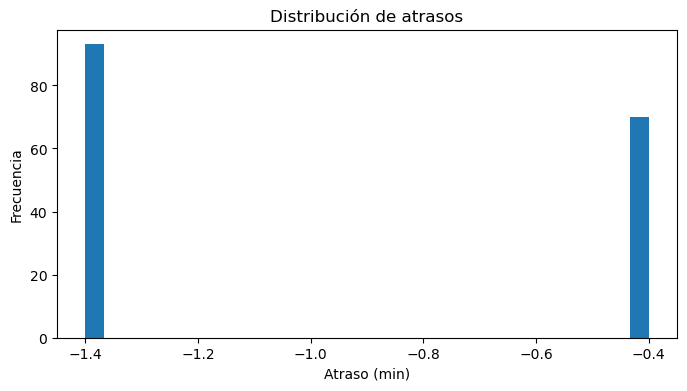

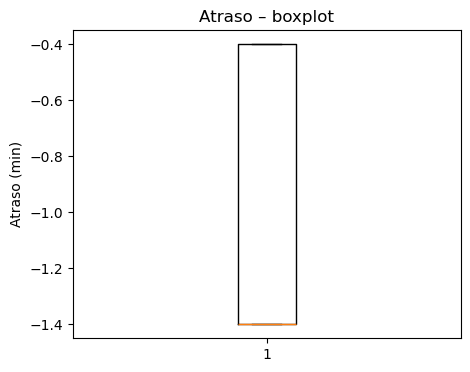

In [10]:
cfg = SimulationConfig(lambda_per_min=0.5, seed=2026)
sim = AEPSimulator(cfg)
out = sim.run()

delays = np.array(out.delays)  # en minutos
print("Atraso medio:", delays.mean() if len(delays) else 0.0)

plt.figure(figsize=(8,4))
plt.hist(delays, bins=30)
plt.xlabel("Atraso (min)")
plt.ylabel("Frecuencia")
plt.title("Distribución de atrasos")
plt.show()

plt.figure(figsize=(5,4))
plt.boxplot(delays, vert=True)
plt.ylabel("Atraso (min)")
plt.title("Atraso – boxplot")
plt.show()


### Análisis completo de congestión y métricas
Vamos a analizar:
1. Relación entre λ y congestión
2. Frecuencia de desvíos
3. Comparación con tiempo ideal
4. Intervalos de confianza para todas las métricas

In [11]:
def analyze_congestion(lams, reps=100, seed=123):
    """
    Analiza congestión, atrasos y desvíos para diferentes valores de lambda
    """
    results = []
    rng = np.random.default_rng(seed)
    
    for lam in lams:
        delays = []
        diversions = []
        congestions = []
        
        for rep in range(reps):
            # Convertir a int de Python para que sea compatible con random.seed()
            seed_value = int(rng.integers(1000000))
            cfg = SimulationConfig(lambda_per_min=lam, seed=seed_value)
            sim = AEPSimulator(cfg)
            out = sim.run()
           
            # Calcular métricas
            delays.append(np.mean(out.delays) if out.delays else 0)
            diversions.append(out.diverted / (out.landed + out.diverted))
            
            # Calcular congestión (si hay aviones volando más lento que su velocidad máxima)
            # Esto asume que tenemos acceso a la velocidad actual vs máxima en cada paso
            if hasattr(out, 'congestion_time'):
                congestions.append(out.congestion_time / OPERATION_MINUTES)
            else:
                congestions.append(0)
                   
        # Calcular estadísticas con error de estimación (IC 95%)
        mean_delay = np.mean(delays)
        delay_ci = 1.96 * np.std(delays) / np.sqrt(reps)
        
        diversion_rate = np.mean(diversions)
        div_ci = 1.96 * np.std(diversions) / np.sqrt(reps)
        
        mean_congestion = np.mean(congestions)
        cong_ci = 1.96 * np.std(congestions) / np.sqrt(reps)
        
        results.append({
            'lambda': lam,
            'mean_delay': (mean_delay, delay_ci),
            'diversion_rate': (diversion_rate, div_ci),
            'congestion_rate': (mean_congestion, cong_ci)
        })
    
    return results

# Correr análisis con más repeticiones
results = analyze_congestion(lams, reps=100, seed=123)

# Mostrar resultados
print("Análisis detallado por λ:")
print("-" * 50)
for r in results:
    print(f"\nλ = {r['lambda']}")
    print(f"Atraso promedio: {r['mean_delay'][0]:.2f} ± {r['mean_delay'][1]:.2f} min")
    print(f"Tasa de desvíos: {r['diversion_rate'][0]:.3%} ± {r['diversion_rate'][1]:.3%}")
    print(f"Tasa de congestión: {r['congestion_rate'][0]:.3%} ± {r['congestion_rate'][1]:.3%}")

Análisis detallado por λ:
--------------------------------------------------

λ = 0.02
Atraso promedio: -0.33 ± 0.17 min
Tasa de desvíos: 1.407% ± 0.485%
Tasa de congestión: 0.592% ± 0.158%

λ = 0.1
Atraso promedio: 0.40 ± 0.14 min
Tasa de desvíos: 23.587% ± 0.739%
Tasa de congestión: 5.512% ± 0.498%

λ = 0.2
Atraso promedio: -0.70 ± 0.06 min
Tasa de desvíos: 45.016% ± 0.454%
Tasa de congestión: 7.928% ± 0.449%

λ = 0.5
Atraso promedio: -0.90 ± 0.01 min
Tasa de desvíos: 69.231% ± 0.156%
Tasa de congestión: 21.277% ± 0.437%

λ = 1.0
Atraso promedio: -0.41 ± 0.00 min
Tasa de desvíos: 83.223% ± 0.000%
Tasa de congestión: 50.370% ± 0.000%


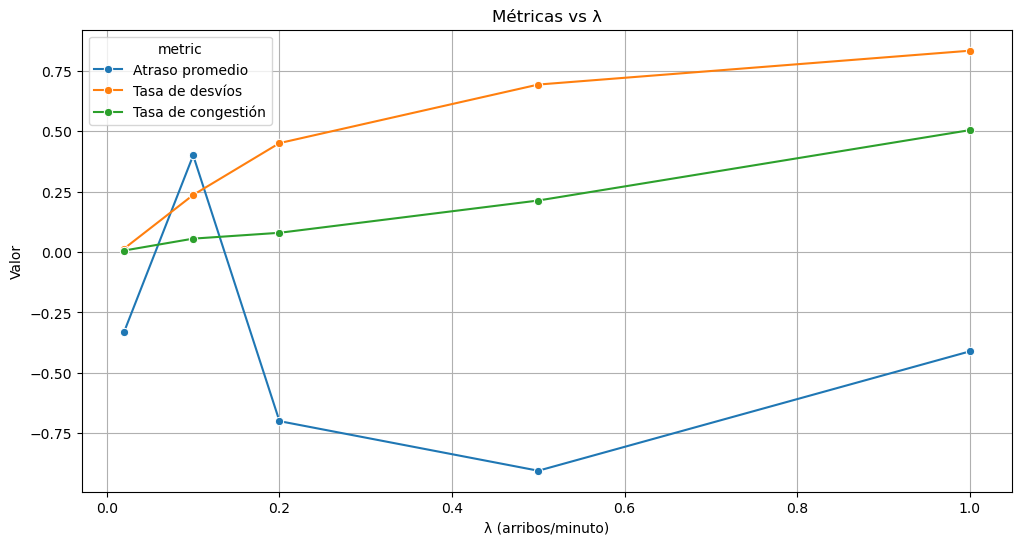

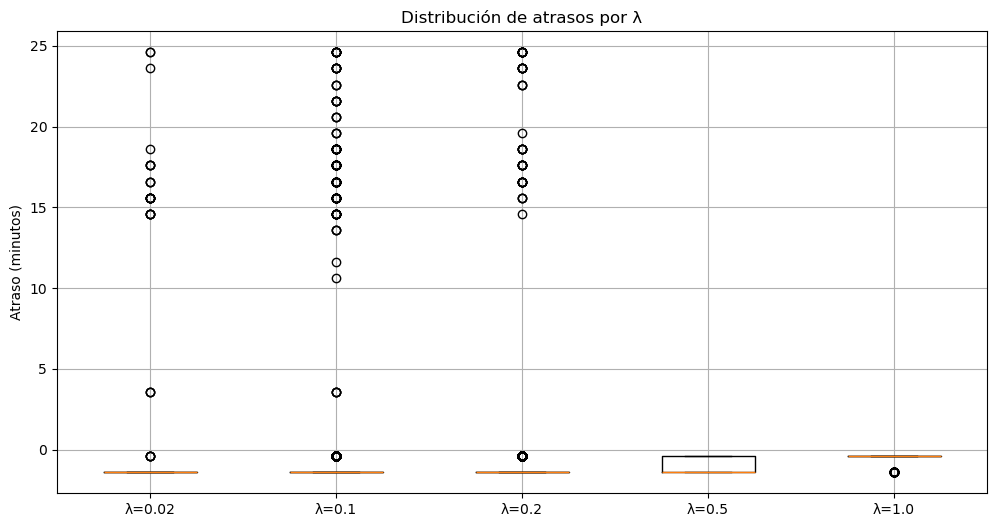

In [12]:
# Visualizaciones comparativas
import seaborn as sns

# Preparar datos para visualización
delay_data = []
diversion_data = []
congestion_data = []

for r in results:
    lam = r['lambda']
    delay_data.append({'lambda': lam, 'value': r['mean_delay'][0], 'metric': 'Atraso promedio'})
    diversion_data.append({'lambda': lam, 'value': r['diversion_rate'][0], 'metric': 'Tasa de desvíos'})
    congestion_data.append({'lambda': lam, 'value': r['congestion_rate'][0], 'metric': 'Tasa de congestión'})

all_data = pd.DataFrame(delay_data + diversion_data + congestion_data)

# Gráfico de líneas para todas las métricas
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='lambda', y='value', hue='metric', marker='o')
plt.title('Métricas vs λ')
plt.xlabel('λ (arribos/minuto)')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Boxplot de atrasos por λ
delays_by_lambda = {lam: [] for lam in lams}
for lam in lams:
    for _ in range(20):  # Menos repeticiones para el boxplot
        cfg = SimulationConfig(lambda_per_min=lam, seed=np.random.randint(1000000))
        sim = AEPSimulator(cfg)
        out = sim.run()
        if out.delays:
            delays_by_lambda[lam].extend(out.delays)

plt.figure(figsize=(12, 6))
box_data = [delays_by_lambda[lam] for lam in lams]
plt.boxplot(box_data, labels=[f'λ={lam}' for lam in lams])
plt.title('Distribución de atrasos por λ')
plt.ylabel('Atraso (minutos)')
plt.grid(True)
plt.show()

### Ej 5
Día ventoso (10% interrupciones por avión)

In [13]:
# Recargar el módulo para aplicar los cambios
import importlib
importlib.reload(aep_sim)

<module 'aep_sim' from 'c:\\Users\\isabe\\OneDrive\\Escritorio\\TP1_ACN\\aep_sim.py'>

In [14]:
res_windy = run_batch(lams, reps=20, seed=123, windy_day=True)
#res_windy

In [15]:
# --- 1) Imprimir resultados de forma clara ---
print("📊 Resultados de la simulación en día ventoso:\n")
for lam, stats in res.items():
    print(f"λ = {lam}")
    print(f"  ✈️ Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"  🔀 Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"  ⏱️ Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"  🔄 Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*50)

📊 Resultados de la simulación en día ventoso:

λ = 0.02
  ✈️ Aterrizados: 22.05 ± 1.14
  🔀 Desvíos a Montevideo: 0.40 ± 0.15
  ⏱️ Atraso promedio: -0.24 ± 0.16 min
  🔄 Go-arounds: 2.40 ± 0.34
--------------------------------------------------
λ = 0.1
  ✈️ Aterrizados: 79.40 ± 0.96
  🔀 Desvíos a Montevideo: 25.05 ± 0.97
  ⏱️ Atraso promedio: 0.29 ± 0.11 min
  🔄 Go-arounds: 33.75 ± 1.37
--------------------------------------------------
λ = 0.2
  ✈️ Aterrizados: 116.70 ± 0.87
  🔀 Desvíos a Montevideo: 93.60 ± 2.66
  ⏱️ Atraso promedio: -0.82 ± 0.06 min
  🔄 Go-arounds: 99.35 ± 2.95
--------------------------------------------------
λ = 0.5
  ✈️ Aterrizados: 162.90 ± 0.54
  🔀 Desvíos a Montevideo: 371.60 ± 3.09
  ⏱️ Atraso promedio: -0.90 ± 0.01 min
  🔄 Go-arounds: 380.25 ± 3.19
--------------------------------------------------
λ = 1.0
  ✈️ Aterrizados: 177.00 ± 0.00
  🔀 Desvíos a Montevideo: 878.00 ± 0.00
  ⏱️ Atraso promedio: -0.41 ± 0.00 min
  🔄 Go-arounds: 900.00 ± 0.00
--------------

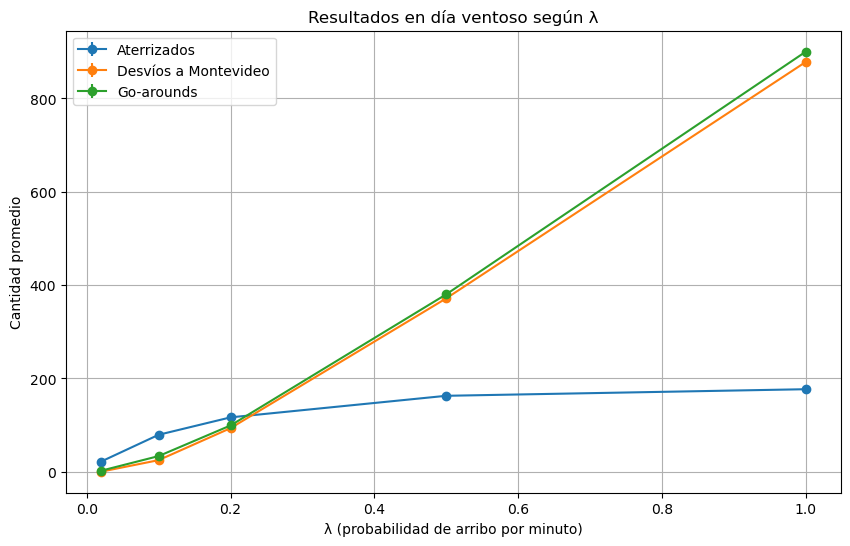

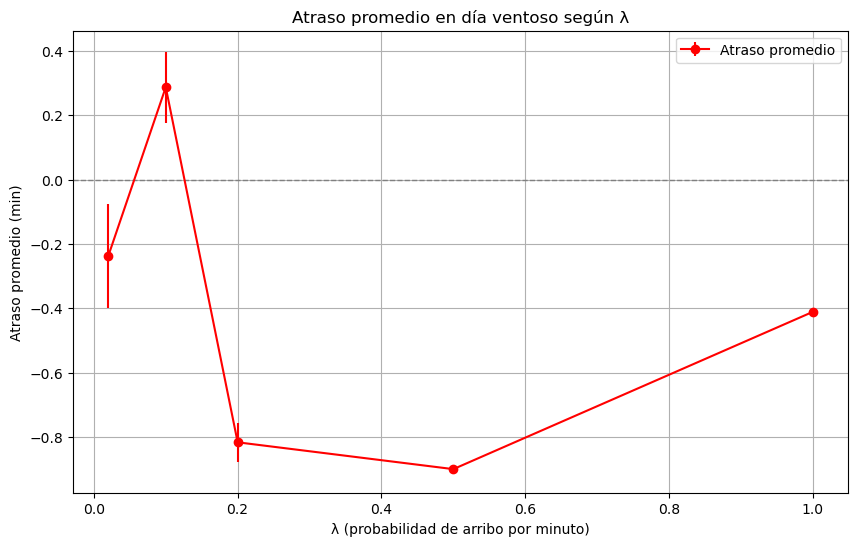

In [16]:
# --- 2) Preparar datos para gráficas ---
lams = list(res.keys())

landed = [res[l]['landed_mean'] for l in lams]
landed_err = [res[l]['landed_se'] for l in lams]

diverted = [res[l]['diverted_mean'] for l in lams]
diverted_err = [res[l]['diverted_se'] for l in lams]

go_around = [res[l]['go_around_mean'] for l in lams]
go_around_err = [res[l]['go_around_se'] for l in lams]

delay = [res[l]['avg_delay_mean'] for l in lams]
delay_err = [res[l]['avg_delay_se'] for l in lams]

# --- 3) Gráfico de aterrizados, desvíos y go-arounds ---
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Resultados en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio")
plt.legend()
plt.grid(True)
plt.show()

# --- 4) Gráfico de atraso promedio ---
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()

Día ventoso + cierre sorpresivo

In [ ]:
# # Día ventoso (10% interrupciones)
# res_windy = run_batch(lams, reps=30, seed=2025, windy_day=True)
# print("Windy day:", res_windy)

# # Cierre sorpresivo 12:00–12:30 (min 360–390)
# res_closure = run_batch(lams, reps=30, seed=2025, closure_window=(360,390))
# print("Closure:", res_closure)

### Ej 6 - Cierre sorpresivo de 30 min
Ejemplo: cierre de 12:00 a 12:30 → minutos 360 a 390.

In [17]:
res_closure = run_batch(lams, reps=20, seed=123, closure_window=(360, 390))
#res_closure

In [18]:
print("🌩️ Resultados de la simulación con tormenta (AEP cerrado 30 min)\n")
for lam, stats in res_closure.items():
    print(f"λ = {lam}")
    print(f"  ✈️ Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"  🔀 Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"  ⏱️ Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"  🔄 Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*55)

🌩️ Resultados de la simulación con tormenta (AEP cerrado 30 min)

λ = 0.02
  ✈️ Aterrizados: 21.95 ± 1.13
  🔀 Desvíos a Montevideo: 0.50 ± 0.15
  ⏱️ Atraso promedio: 0.13 ± 0.18 min
  🔄 Go-arounds: 3.05 ± 0.44
-------------------------------------------------------
λ = 0.1
  ✈️ Aterrizados: 77.50 ± 0.91
  🔀 Desvíos a Montevideo: 26.95 ± 0.99
  ⏱️ Atraso promedio: 0.28 ± 0.12 min
  🔄 Go-arounds: 35.80 ± 1.36
-------------------------------------------------------
λ = 0.2
  ✈️ Aterrizados: 113.10 ± 0.89
  🔀 Desvíos a Montevideo: 97.20 ± 2.68
  ⏱️ Atraso promedio: -0.79 ± 0.06 min
  🔄 Go-arounds: 103.00 ± 2.96
-------------------------------------------------------
λ = 0.5
  ✈️ Aterrizados: 157.75 ± 0.54
  🔀 Desvíos a Montevideo: 376.75 ± 3.13
  ⏱️ Atraso promedio: -0.88 ± 0.01 min
  🔄 Go-arounds: 385.40 ± 3.23
-------------------------------------------------------
λ = 1.0
  ✈️ Aterrizados: 172.00 ± 0.00
  🔀 Desvíos a Montevideo: 883.00 ± 0.00
  ⏱️ Atraso promedio: -0.41 ± 0.00 min
  🔄 G

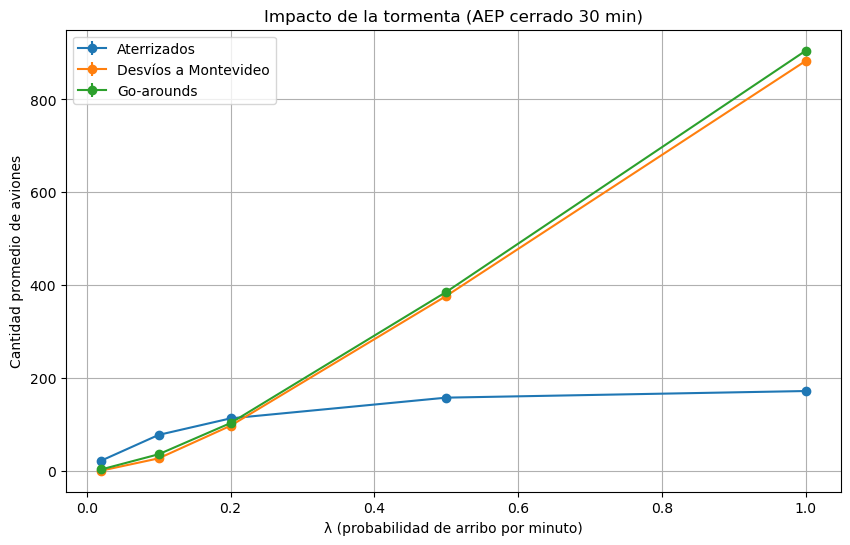

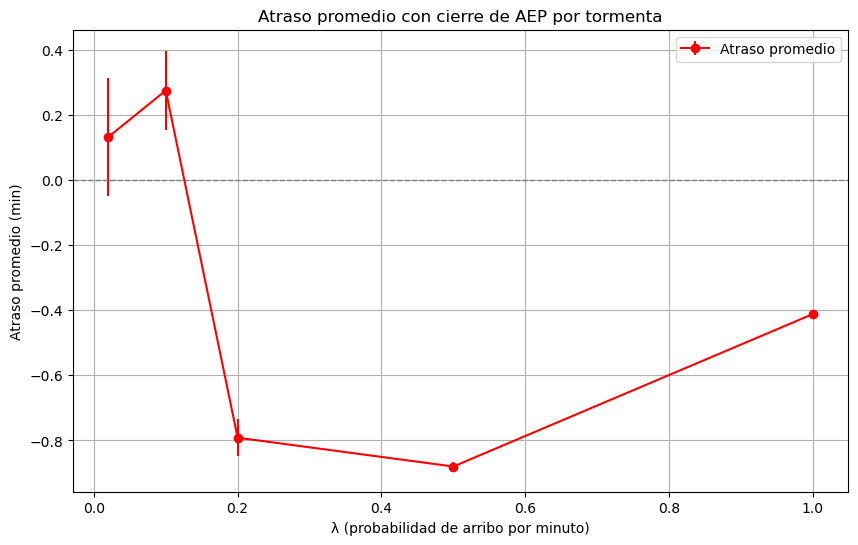

In [19]:
# --- Datos para graficar ---
lams = list(res_closure.keys())

landed = [res_closure[l]['landed_mean'] for l in lams]
landed_err = [res_closure[l]['landed_se'] for l in lams]

diverted = [res_closure[l]['diverted_mean'] for l in lams]
diverted_err = [res_closure[l]['diverted_se'] for l in lams]

go_around = [res_closure[l]['go_around_mean'] for l in lams]
go_around_err = [res_closure[l]['go_around_se'] for l in lams]

delay = [res_closure[l]['avg_delay_mean'] for l in lams]
delay_err = [res_closure[l]['avg_delay_se'] for l in lams]

# --- Gráfico 1: Aterrizados, desvíos y go-arounds ---
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Impacto de la tormenta (AEP cerrado 30 min)")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio de aviones")
plt.legend()
plt.grid(True)
plt.show()

# --- Gráfico 2: Atraso promedio ---
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio con cierre de AEP por tormenta")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- DEBUG RÁPIDO ----------
print("DEBUG: identidad de variables")
try:
    print("res_windy es res_closure?", res_windy is res_closure)
except NameError:
    print("No existe alguna de las variables res_windy / res_closure en este entorno.")

# Chequeo elemento a elemento si son exactamente iguales (raro que pase)
def exact_equality_check(a, b, tol=1e-9):
    keys = sorted(set(a.keys()) | set(b.keys()))
    all_equal = True
    for lam in keys:
        if lam not in a or lam not in b:
            print(f"λ={lam}: falta en uno de los dicts")
            all_equal = False
            continue
        for k in a[lam]:
            if abs(a[lam][k] - b[lam][k]) > tol:
                print(f"λ={lam} difiere en {k}: {a[lam][k]} vs {b[lam][k]}")
                all_equal = False
    if all_equal:
        print("Los diccionarios son (prácticamente) idénticos.")
    else:
        print("Hay diferencias (esperado).")

exact_equality_check(res_windy, res_closure)


# ---------- IMPRESIÓN CLARA ----------
def pretty_print(res, title):
    print("\n" + title + "\n" + "-"*len(title))
    for lam in sorted(res.keys()):
        s = res[lam]
        print(f"λ = {lam}")
        print(f"  ✈️  Aterrizados: {s['landed_mean']:.2f} ± {s['landed_se']:.2f}")
        print(f"  🔀  Desvíos a Montevideo: {s['diverted_mean']:.2f} ± {s['diverted_se']:.2f}")
        print(f"  ⏱️  Atraso promedio: {s['avg_delay_mean']:.2f} ± {s['avg_delay_se']:.2f} min")
        print(f"  🔄  Go-arounds: {s['go_around_mean']:.2f} ± {s['go_around_se']:.2f}")
        # 95% CI (aprox)
        for m in ['landed','diverted','avg_delay','go_around']:
            mean = s[f"{m}_mean"]; se = s[f"{m}_se"]
            low = mean - 1.96*se; high = mean + 1.96*se
            print(f"     95% CI {m}: [{low:.2f}, {high:.2f}]")
        print("-"*50)

pretty_print(res_windy, "Resultados - Día ventoso (res_windy)")
pretty_print(res_closure, "Resultados - Tormenta / Cierre 30min (res_closure)")


# ---------- COMPARACIÓN NUMÉRICA Y SIGNIFICANCIA APROXIMADA ----------
def compare_results(a, b, name_a="windy", name_b="closure"):
    rows = []
    metrics = ['landed', 'diverted', 'avg_delay', 'go_around']
    lams = sorted(set(a.keys())|set(b.keys()))
    for lam in lams:
        for m in metrics:
            m1 = a[lam][f"{m}_mean"]; se1 = a[lam][f"{m}_se"]
            m2 = b[lam][f"{m}_mean"]; se2 = b[lam][f"{m}_se"]
            diff = m1 - m2
            denom_rel = (abs(m1)+abs(m2))/2 if (abs(m1)+abs(m2))>0 else np.nan
            rel_pct = 100*diff/denom_rel if not np.isnan(denom_rel) else np.nan
            denom_se = math.sqrt(se1**2 + se2**2)
            z = diff/denom_se if denom_se>0 else np.nan
            signif = (not np.isnan(z)) and (abs(z) > 1.96)
            rows.append({
                'λ': lam, 'metric': m,
                f'{name_a}_mean': m1, f'{name_a}_se': se1,
                f'{name_b}_mean': m2, f'{name_b}_se': se2,
                'diff': diff, 'rel_pct': rel_pct, 'z_score': z, 'significant(95%)': signif
            })
    df = pd.DataFrame(rows)
    # mostrar ordenado
    pd.set_option('display.float_format', '{:.2f}'.format)
    return df

df_comp = compare_results(res_windy, res_closure, "windy", "closure")
display(df_comp)


# ---------- GRAFICOS LADO A LADO ----------
def plot_side_by_side(a, b, name_a="windy", name_b="closure"):
    lams = sorted(a.keys())
    x = np.arange(len(lams))
    width = 0.35

    # Preparar arrays por métrica
    def arrs(metric):
        A = [a[l][f"{metric}_mean"] for l in lams]
        AE = [a[l][f"{metric}_se"] for l in lams]
        B = [b[l][f"{metric}_mean"] for l in lams]
        BE = [b[l][f"{metric}_se"] for l in lams]
        return np.array(A), np.array(AE), np.array(B), np.array(BE)

    fig, axes = plt.subplots(2,2, figsize=(14,9))
    axs = axes.flatten()
    metrics = ['landed','diverted','go_around','avg_delay']
    titles = ['Aterrizados','Desvíos a Montevideo','Go-arounds','Atraso promedio (min)']

    for ax, metric, title in zip(axs, metrics, titles):
        A, AE, B, BE = arrs(metric)
        ax.bar(x - width/2, A, width, yerr=AE, label=name_a, alpha=0.9, capsize=4)
        ax.bar(x + width/2, B, width, yerr=BE, label=name_b, alpha=0.9, capsize=4)
        ax.set_xticks(x)
        ax.set_xticklabels(lams)
        ax.set_title(title)
        ax.set_xlabel("λ")
        if metric != 'avg_delay':
            ax.set_ylabel("Cantidad promedio")
        else:
            ax.set_ylabel("Minutos")
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_side_by_side(res_windy, res_closure, "Ventoso", "Cierre30min")


## TODOs sugeridos (para llegar al 100% del enunciado)
- Refinar la lógica de **reinserción** tras go-around: buscar explícitamente el primer hueco ≥10 min y forzar el giro cuando se cumpla y la distancia sea >5 mn.
- Visualización de **trayectorias** (distancia vs. tiempo) para varios aviones en un mismo gráfico, coloreando por estado (approach, go-around, landed, diverted).
- Cálculo de **probabilidad de 5 arribos en una hora** para el caso de $\lambda$ que implica 1 avión/hora (comparar con Poisson/Binomial) y validarlo por simulación.
- Medir **atraso promedio** con distribución completa (boxplots) y su error de estimación (IC 95%).
